# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
all_data = pd.read_csv('alldata.csv')
dr_data = pd.read_csv('drdata.csv')
drq_data = pd.read_csv('drq.csv')
elected_data = pd.read_csv('electeddata.csv')
tv2_data = pd.read_csv('tv2data.csv')
tv2q_data = pd.read_csv('tv2q.csv')

data_questions = all_data.copy()
data_questions = data_questions.select_dtypes(include=['number'])
data_questions = data_questions.drop(columns=['alder'])

**1. An analysis/description of which questions are most crucial concerning their placement on the axes.**

In [60]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)
scaler = StandardScaler()

data_questions_scaled = scaler.fit_transform(data_questions)
data_questions_pca = pca.fit_transform(data_questions_scaled)
pca_df = pd.DataFrame(data_questions_pca, columns=['PC1', 'PC2'])

pca_df['parti'] = all_data['parti'] 
pca_df['navn'] = all_data['navn']

pca_loadings = pd.DataFrame(pca.components_.T, index=data_questions.columns, columns=['PC1', 'PC2'])

pc1_sorted = pca_loadings['PC1'].abs().sort_values(ascending=False).head(10)
pc2_sorted = pca_loadings['PC2'].abs().sort_values(ascending=False).head(10)


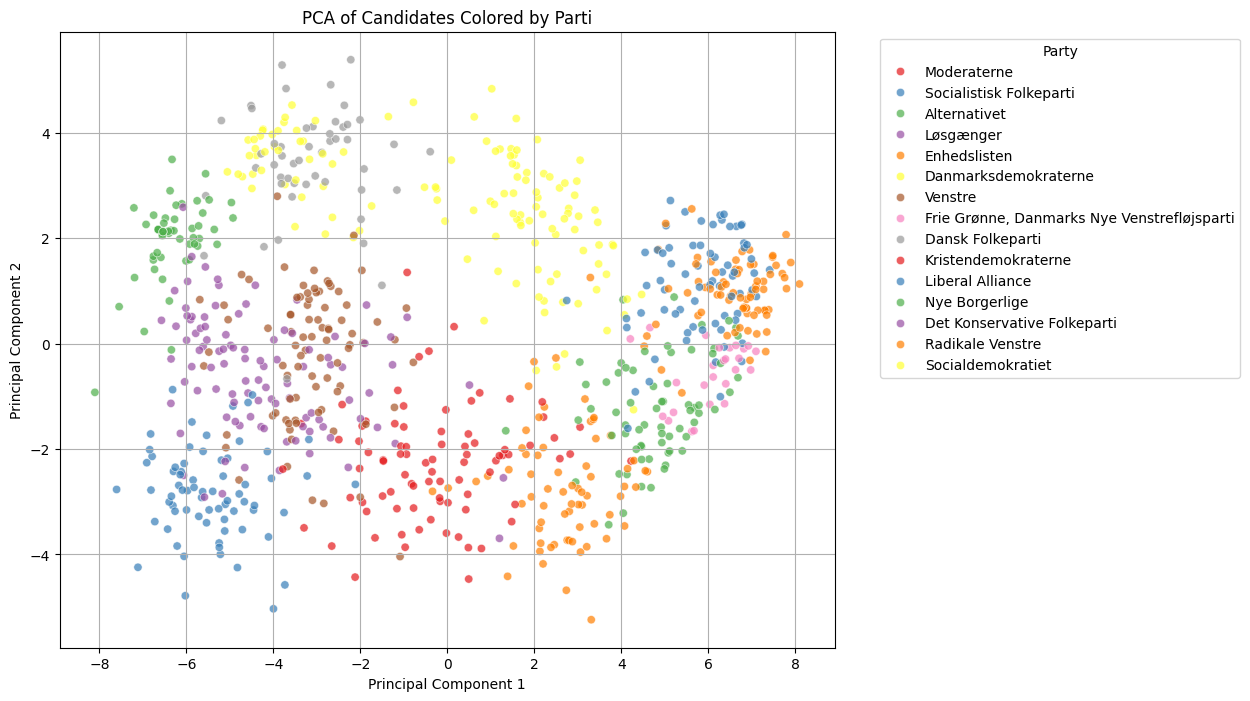

In [61]:
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='parti', palette='Set1', alpha=0.7)
plt.title('PCA of Candidates Colored by Parti')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Party', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

In [62]:
print("Top contributing questions to PC1:\n", pc1_sorted)
print("\nTop contributing questions to PC2:\n", pc2_sorted)

Top contributing questions to PC1:
 530    0.190641
537    0.190284
4a     0.188849
3b     0.188778
550    0.188555
531    0.187016
543    0.185893
548    0.176281
559    0.176279
540    0.174404
Name: PC1, dtype: float64

Top contributing questions to PC2:
 10b    0.302918
556    0.297979
551    0.293836
553    0.272808
4b     0.258449
5a     0.228295
6a     0.208142
6b     0.207708
555    0.206750
534    0.201447
Name: PC2, dtype: float64


The first component (PC1) reflects a traditional left-right economic and climate divide by questions on public transport, taxation, and inequality (e.g., Q530, Q537, Q4a). The second component (PC2) captures value-based and security issues, with contributions from questions on immigration, justice, and religious funding (e.g., Q10b, Q556, Q4b).


**2. Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.**

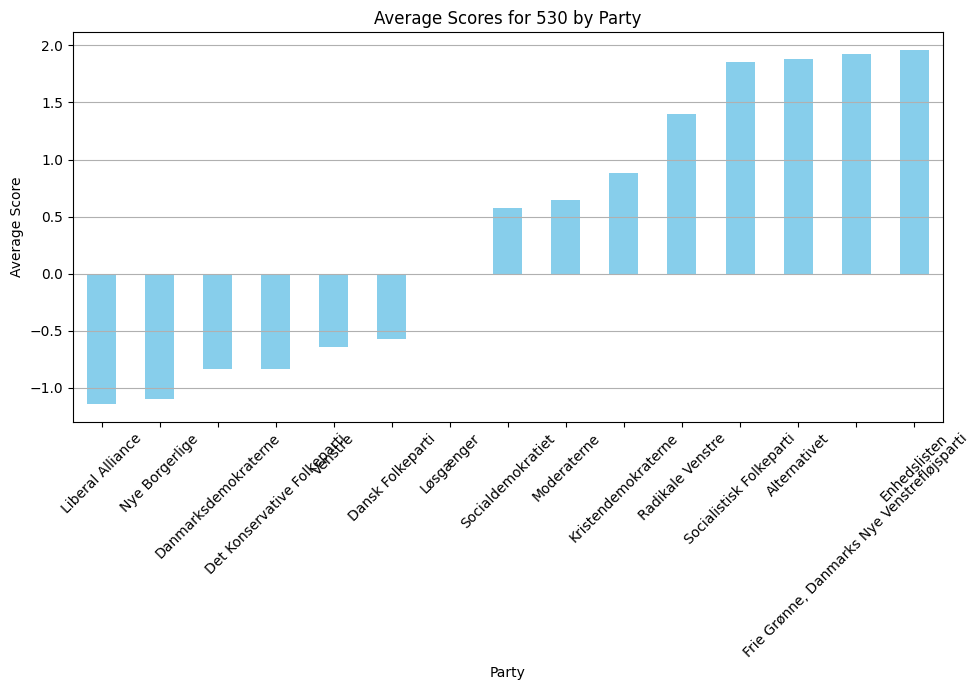

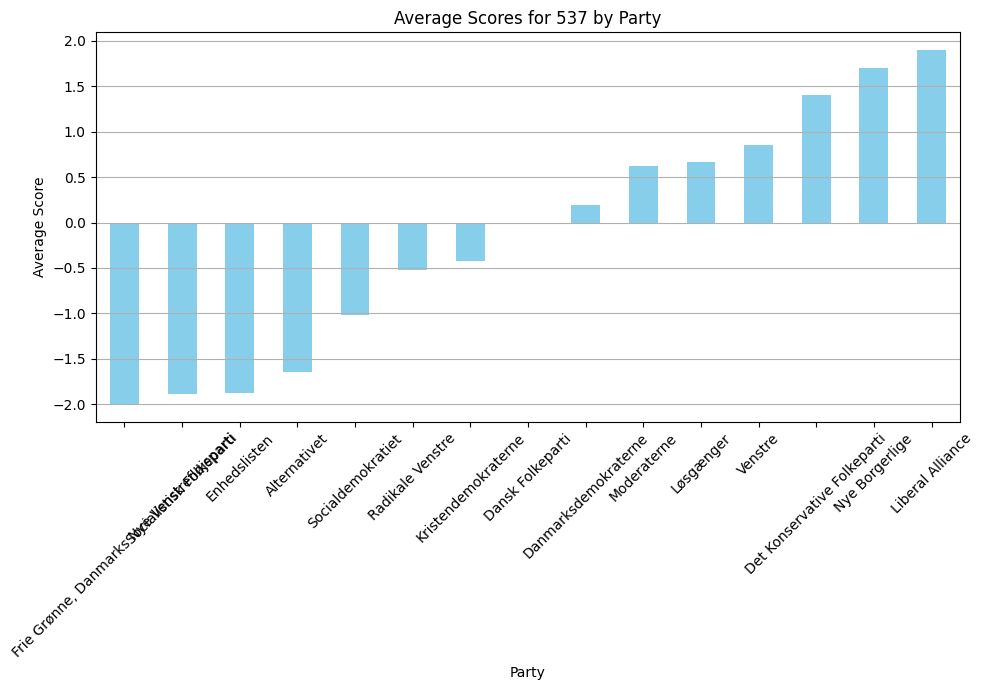

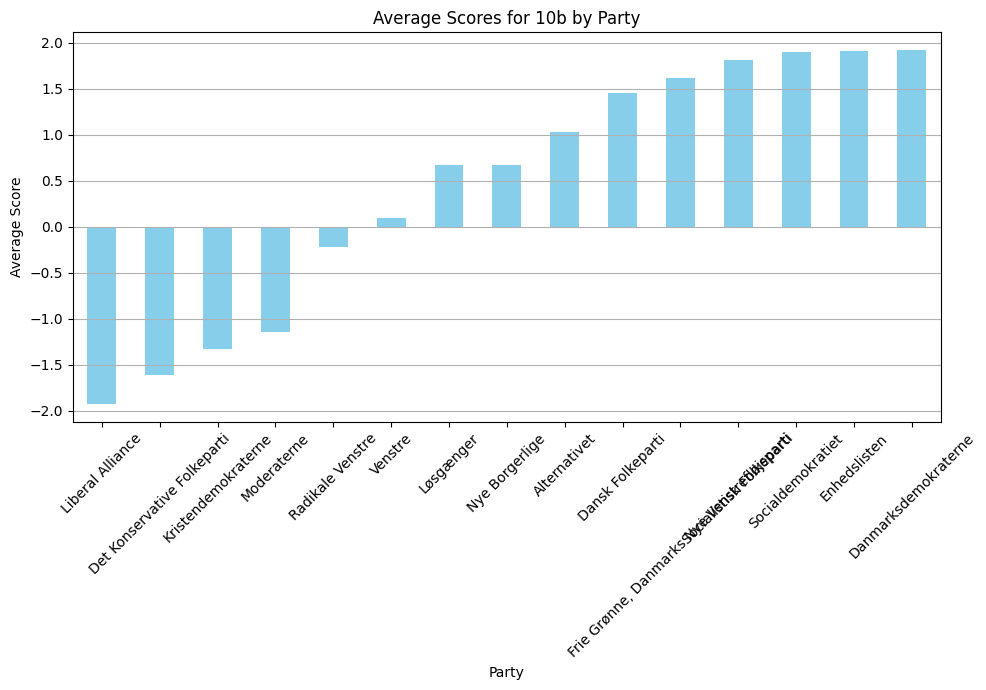

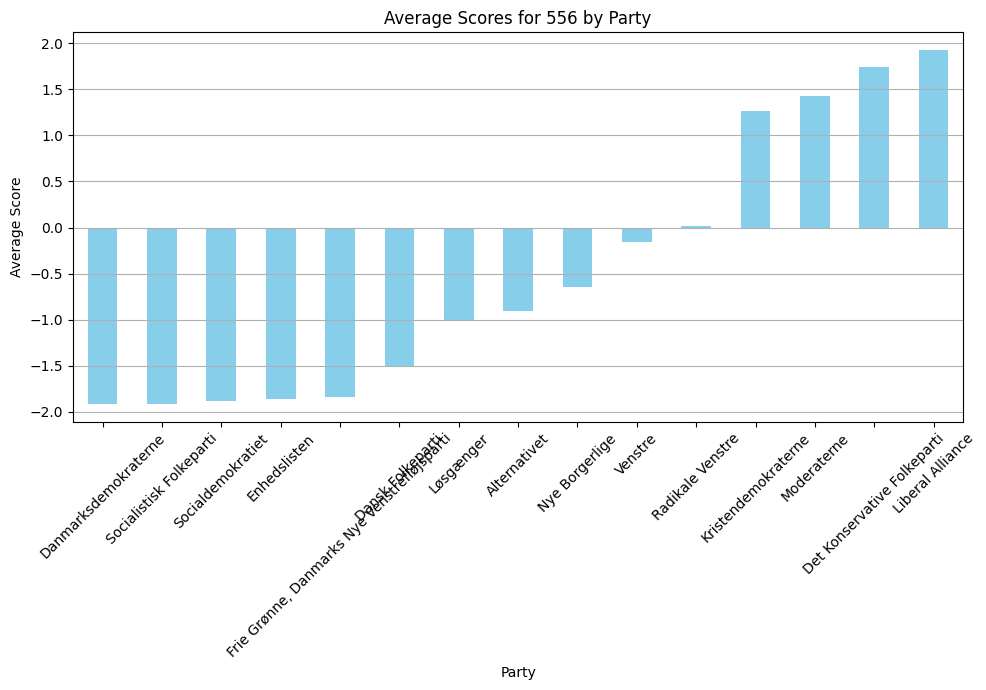

In [63]:
question_columns = data_questions.columns
avg_scores = all_data.groupby('parti')[question_columns].mean()

questions = pc1_sorted.head(2).index.tolist() + pc2_sorted.head(2).index.tolist()

for question in questions:
    plt.figure(figsize=(10, 7))
    avg_scores[question].sort_values().plot(kind='bar', color='skyblue')
    plt.title(f'Average Scores for {question} by Party')
    plt.xlabel('Party')
    plt.ylabel('Average Score')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

**3.** A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**

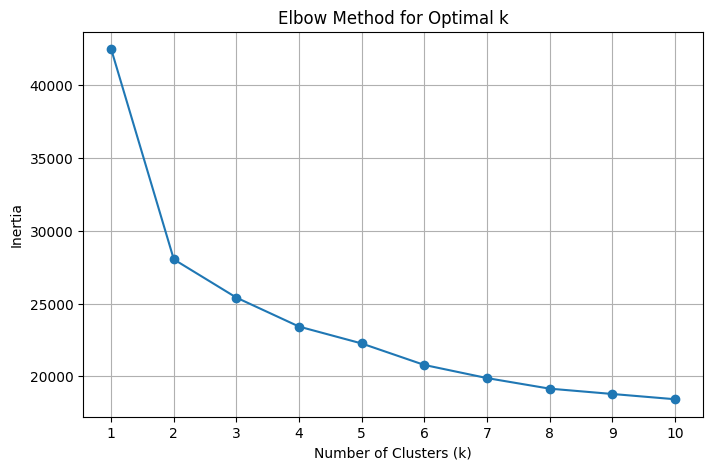

In [64]:
from sklearn.cluster import KMeans, DBSCAN
import numpy as np

#elbow method for k-means
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_questions_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid()
plt.show() 

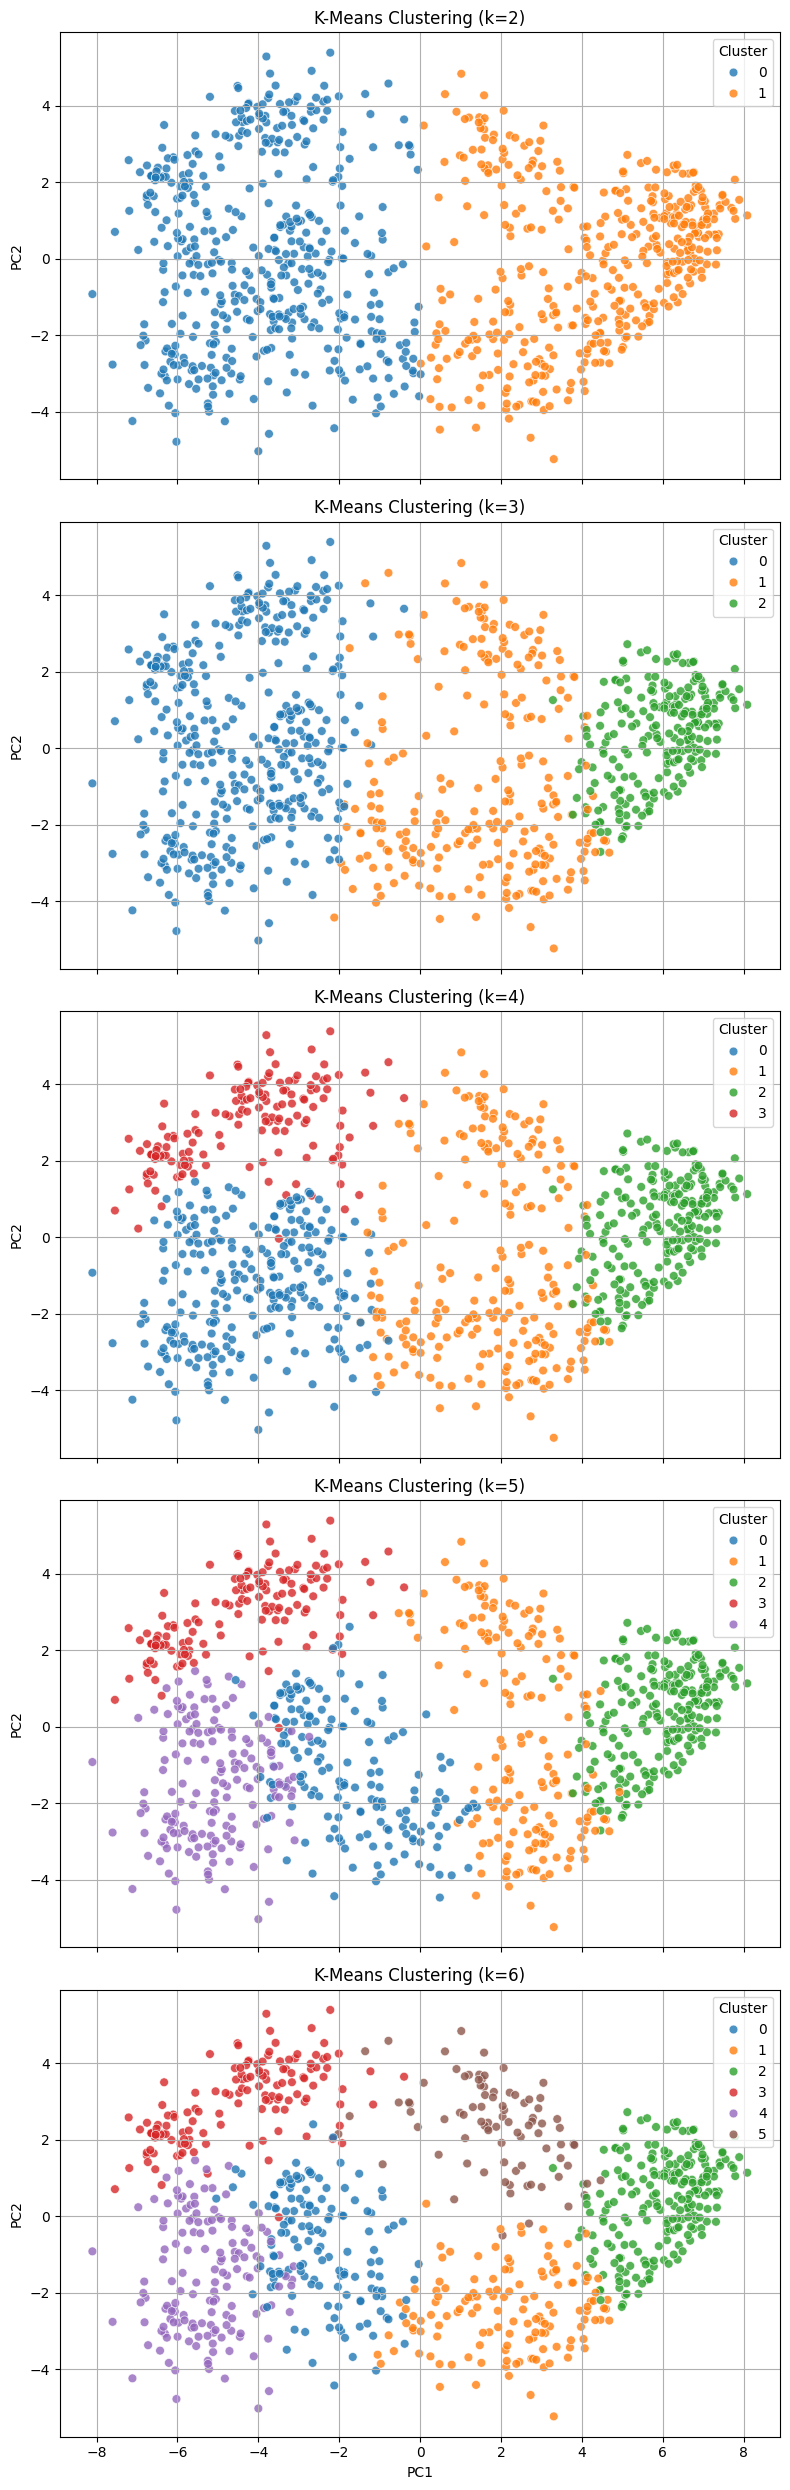

In [65]:
k_values = [2, 3, 4, 5, 6]

# subplots
fig, axes = plt.subplots(len(k_values), 1, figsize=(8, 5 * len(k_values)), sharex=True, sharey=True)

for i, k in enumerate(k_values):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_questions_scaled)

    temp_df = pca_df.copy()
    temp_df['cluster'] = labels

    sns.scatterplot(
        data=temp_df,
        x='PC1',
        y='PC2',
        hue='cluster',
        palette='tab10',
        s=40,
        alpha=0.8,
        ax=axes[i]
    )

    axes[i].set_title(f'K-Means Clustering (k={k})')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
    axes[i].legend(title='Cluster', loc='upper right')
    axes[i].grid()

plt.tight_layout()
plt.show()

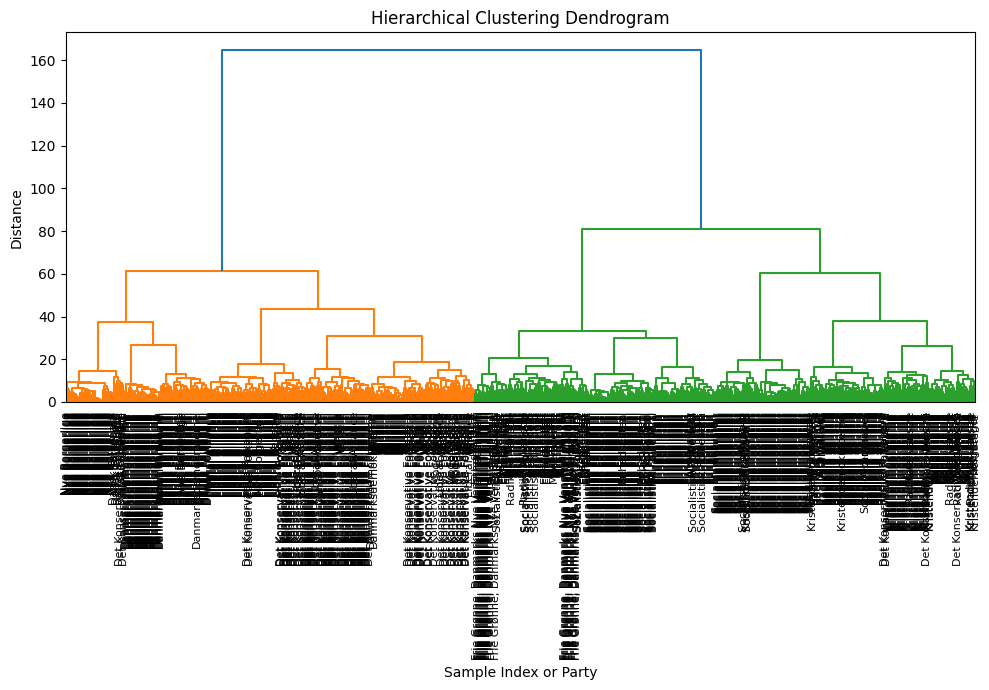

In [66]:
# hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering

# Perform hierarchical clustering
linked = linkage(data_questions_scaled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, labels=all_data['parti'].values, leaf_rotation=90, leaf_font_size=8, color_threshold=100)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index or Party')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

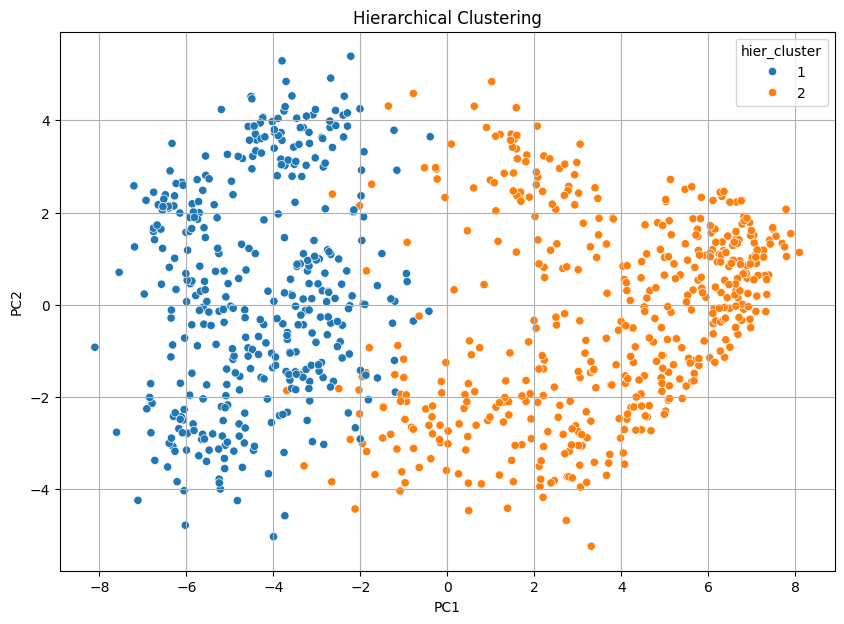

In [67]:
clusters_hier = fcluster(linked, t=2, criterion='maxclust')
pca_df['hier_cluster'] = clusters_hier

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='hier_cluster', palette='tab10')
plt.title('Hierarchical Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

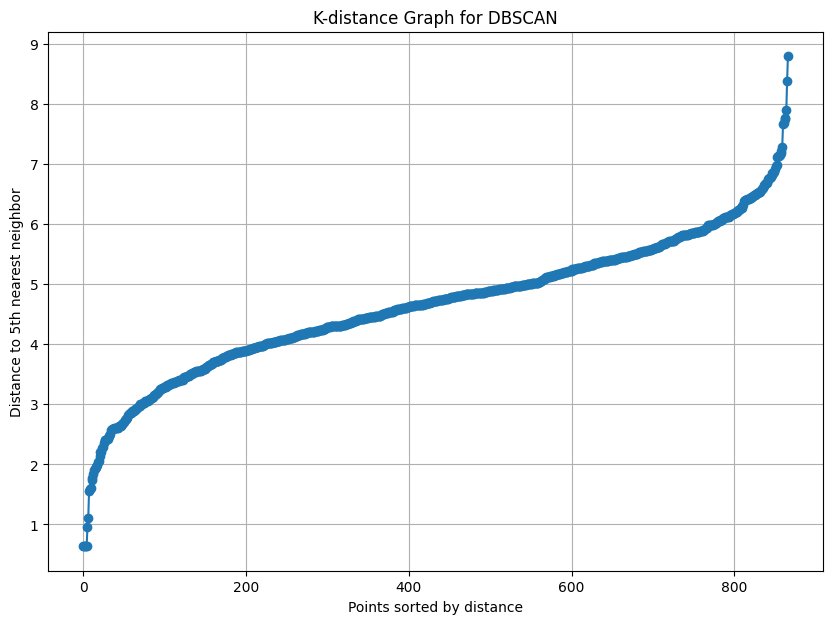

In [68]:
# DBSCAN clustering
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5)

neighbors_fit = neighbors.fit(data_questions_scaled)
k_neighbors = neighbors_fit.kneighbors(data_questions_scaled)
distances, indices = k_neighbors
distances = np.sort(distances[:, 4])

plt.figure(figsize=(10, 7))
plt.plot(distances, marker='o')
plt.title('K-distance Graph for DBSCAN')
plt.xlabel('Points sorted by distance')
plt.ylabel('Distance to 5th nearest neighbor')
plt.grid()
plt.show()

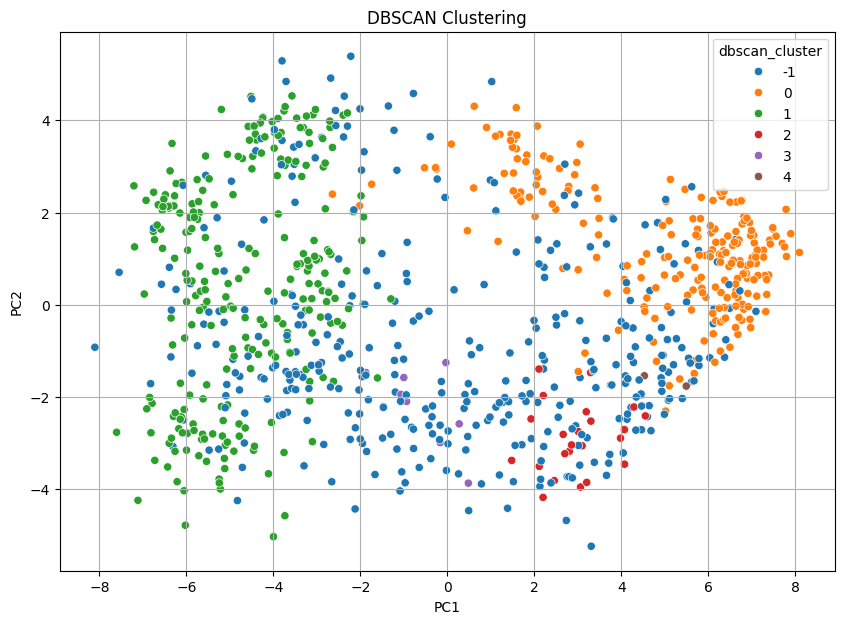

In [69]:
dbscan = DBSCAN(eps=4.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_questions_scaled)

pca_df['dbscan_cluster'] = dbscan_labels

plt.figure(figsize=(10, 7))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='dbscan_cluster', palette='tab10')
plt.title('DBSCAN Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid()
plt.show()

**Discussion**
- **K-Means**: The elbow plot showed a bend around 3–4 clusters, and the visualizations for different k-values shoes that some parties fall into the same cluster. This suggests that some parties are very similar ideologically and could be merged or simplified.
- **Hierarchical** clustering: The dendrogram and cluster visualization showed that candidates from different parties often appear in the same cluster. Again, this shows overlapping views and supports the idea that fewer, broader parties might better reflect these groupings.
- **DBSCAN**: The density-based clustering showed that some candidates are outliers, indicating that they have very different views from the rest. This could suggest that these candidates might not fit well within the existing party structure and could be candidates for new parties or movements.

**4. An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.**

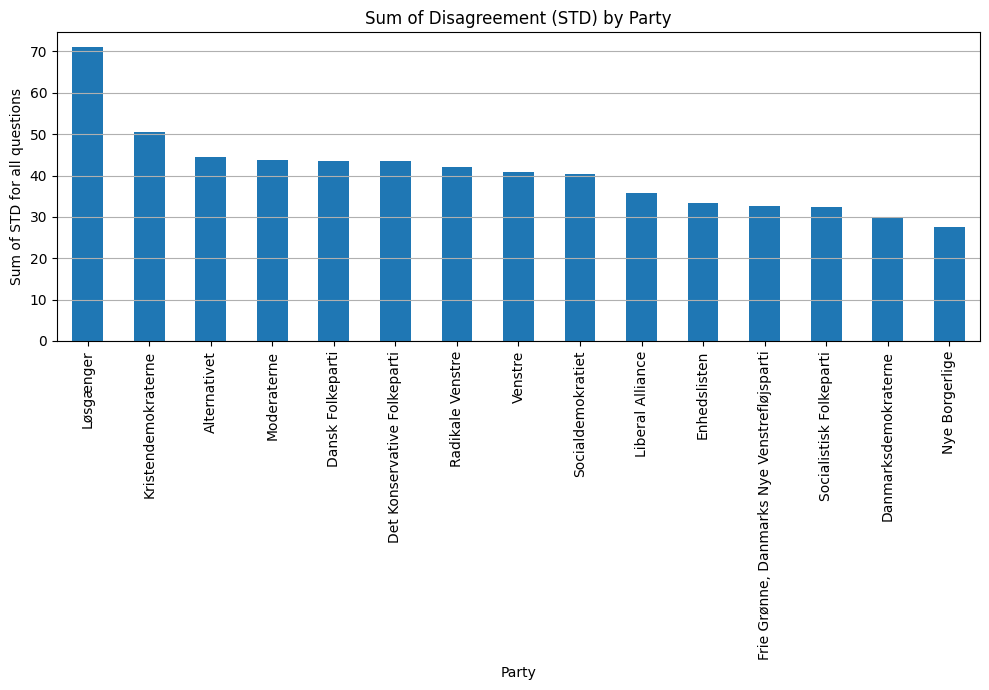

In [71]:
scores_std = all_data.groupby('parti')[question_columns].std()

sums = scores_std.sum(axis=1).sort_values(ascending=False)
sums.plot(kind='bar', figsize=(10, 7))
plt.title('Sum of Disagreement (STD) by Party')
plt.ylabel('Sum of STD for all questions')
plt.xlabel('Party')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [75]:
from sklearn.metrics.pairwise import euclidean_distances

parti_avg = all_data.groupby('parti')[question_columns].mean()

distance_to_parti=[]
for i, row in all_data.iterrows():
    parti = row['parti']
    if parti in parti_avg.index:
        distance = np.linalg.norm(row[question_columns] - parti_avg.loc[parti])
        distance_to_parti.append((distance))
    else:
        distance_to_parti.append((np.nan))

all_data['distance_to_parti_avg'] = distance_to_parti

top_divergent = all_data.sort_values(by='distance_to_parti_avg', ascending=False)[['navn', 'parti', 'distance_to_parti_avg']].head(10)

print("Top 10 Divergent Candidates:\n")
display(top_divergent)

Top 10 Divergent Candidates:



,navn,parti,distance_to_parti_avg
679,Mads Silberg,Det Konservative Folkeparti,12.650819
653,Finn Andersen,Kristendemokraterne,11.916233
88,Søren Vanting,Det Konservative Folkeparti,10.671455
89,Per Urban Olsen,Det Konservative Folkeparti,10.523169
816,Lars Prier,Dansk Folkeparti,10.186515
155,Paw Karslund,Dansk Folkeparti,10.097979
567,Dorthe Schmittroth,Det Konservative Folkeparti,10.016433
326,Diana-Ester Eriksen,Det Konservative Folkeparti,9.909918
3,Nicklas Gjedsig Larsen,Alternativet,9.905164
250,Phillip Sperling,Venstre,9.864681
